# EE121 final project code

In [25]:
import numpy as np
import scipy as sci
import scipy.io as scio
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
def binary_search(lst, val):
    '''
    returns the highest index in sorted lst containing a value less than val
    '''
    i = len(lst)/2
    low = 0
    high = len(lst)
    while abs(low-high) > 1:
#         print i, low, high, lst[i]
        if val > lst[i]:
            if i == len(lst)-1:
                return i
            low = i
            i += len(lst[i:high])/2
        if val < lst[i]:
            high = i
            i -= len(lst[low:i])/2
        if val == lst[i]:
            return i
    return low

In [3]:
def sample_one_dist(n, pdf):
    '''
    take n samples from a one dim pdf
    '''
    total = 0
    cdf = [total]
    for prob in pdf:
        total += prob
        cdf.append(total)
    pulls = np.random.rand(n)
    samples = []
#     print cdf
    for i in pulls:
#         print i
        samples.append(binary_search(cdf, i))
    return samples

def create_distribution(n, d):
    '''
    Creates a set of random samples, with n samples and quantization d, that is,
    the distribution takes on 2^d different values

    the return value is a tuple, containing the generated samples and the pdf of the
    function that generated them
    '''
    pdf = np.random.rand(2**d)
    pdf = pdf/np.sum(pdf)
    samples = sample_one_dist(n, pdf)


    return samples, pdf


In [4]:
samples, pdf =  create_distribution(1000, 4)

In [5]:
a = np.array([[1,3],[2,3]])
b = np.array([[.1,.2], [.3,2]])
np.log(a/b)

array([[ 2.30258509,  2.7080502 ],
       [ 1.89711998,  0.40546511]])

In [193]:
def kl_divergence(px1, px2):
    '''
    computes the kl_divergence between two distributions assumed vector form
    '''
    return np.nan_to_num(np.sum(px1 * np.log2(px1/px2)))

def expanded_kl_divergence(pyx1, pyt2):
    '''
    computes the kl_divergence between two joint distributions,
    summing out the mutual variable, and returning a matrix of shape
    t by x
    '''
    joint_dist = np.ones((pyt2.shape[1], pyx1.shape[1]))
    for xi in range(pyx1.shape[1]):
        for ti in range(pyt2.shape[1]):
            joint_dist[ti, xi] = kl_divergence(pyx1[:,xi], pyt2[:,ti])
    return joint_dist

def js_divergence(px1, px2, pi):
    '''
    computes the js divergence between two distributions
    '''
    pbar = multi_sum_dist(px1, px2, pi)
#     print pbar
    return pi[0] * kl_divergence(px1, pbar) + pi[1] * kl_divergence(px2, pbar)

def entropy(px):
    '''
    Computes the entropy of a distributon with probability vector px
    '''
    return np.sum([-p*np.log2(p) for p in px])

def relative_entropy(px, pyx):
    '''
    Computes the relative entropy between two distributions, based on the dependence
    matrix
    '''
    return np.sum([psx*np.sum(
        [pyx[y,x] *np.log2(pyx[y,x]
            ) for y in range(pyx.shape[0])])
             for psx in px])

In [143]:
x = np.array([.2, .8])
t = np.array([.3, .7])
yx = np.array([[.3, .4, .8],[.7, .6, .2]])
# y = np.sum(expand(x, 2)*yx, axis=1)
print multi_sum_dist(yx, yx, (.5,.5))
print js_divergence(yx,yx, (.5,.5))

[[ 0.09  0.16  0.64]
 [ 0.49  0.36  0.04]]
2.57416958857


In [128]:
def kmeans(images, num_clusters, num_iters=50):
    '''
    performs k-means clustering on a set of data
    '''
    # choose clusters points as centers
    center_locs = []
    centers = []
    clusters = []

    prev_loss = -1
    for i in range(num_clusters):
        new_center = np.random.randint(len(images))
        while (new_center in center_locs):
            new_center = np.random.randint(len(images))
        center_locs.append(new_center)
        centers.append(images[new_center])
        clusters.append([])

    total_loss = 0
    curr_iters = 0
    while (prev_loss != total_loss and curr_iters < num_iters):
        prev_loss = total_loss
        total_loss = 0
        # assign points to clusters
        for image in images:
            best_center = 0
            best_dist = np.linalg.norm(image - centers[0])
            for i in range(len(centers)):
                dist = np.linalg.norm(image - centers[i])
                if dist < best_dist:
                    best_center = i
                    best_dist = dist
            # find loss
            clusters[best_center].append(image)
            total_loss += best_dist

        # update centers
        for i in range(len(clusters)):
            updated_center = np.mean(clusters[i], axis=0)
            centers[i] = updated_center
            
        curr_iters+=1
        
    # if loss changed, repeat as before
    
    return centers, clusters

def empirical_dist(x):
    '''
    Construct a distribution for samples x
    '''
    pxh = Counter()

    for val in x:
        pxh[val] += 1
    total = 0.0
    px = []
    for i in range(np.max(pxh.keys())+1):
        px.append(pxh[i])
        total += pxh[i]
    return np.array(px)/total

def empirical_dependent_dist(x, y):
    '''
    given x with corresponding labels y, determine the
    distribution of P(y|x)
    '''
    Pyxc = Counter()
    yvals = []
    xvals = []
    y = y.reshape(y.shape[0],)
    for i in range(len(x)):
        xv = x[i]
        yv = y[i]
        Pyxc[(yv,xv)] += 1
        yvals.append(yv)
        xvals.append(xv)
    yvals = set(yvals)
    xvals = set(xvals)
    
    print Pyxc
    ixv = list(xvals)
    iyv = list(yvals)
    ixv.sort()
    iyv.sort()
    Pyx = np.ones((int(np.max(iyv))+1, int(np.max(ixv))+1))
    colvals = []
    for xv in range(np.max(ixv)+1):
        coltotal = 0
        for yv in range(np.max(iyv)+1):
            coltotal += Pyxc[(yv, xv)]
        if coltotal == 0:
            coltotal = .0001
        colvals.append(coltotal)
    colvals = np.array(colvals)
    for i in range(np.max(iyv)+1):
        for j in range(np.max(ixv)+1): 
            Pyx[i,j] = Pyxc[(i,j)]
    return Pyx, colvals

def shuffle_in_unison(a, b):
    '''
    shuffles a, b the same way
    '''
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
def cluster_classify(class_fun, images, labels):
    '''
    applies class_fun to each of the images, and compares with true label
    '''
    errors = 0.0
    total = float(labels.shape[0])
    assumed_labels = []
    for i in range(images.shape[0]):
        image = images[i]
        res = class_fun(image)
        assumed_labels.append(res)
        if res != labels[i]:
            errors += 1
    return errors/total, assumed_labels
        
def assign_centers(means, images):
    '''
    assigns each image to the value of the l2 closest mean
    '''
    assigned = []
    for im in images:
        lowest = np.linalg.norm(means[0])
        bstidx = 0
        idx = 0
        for mean in means:
            dist = np.linalg.norm(mean-im)
            if dist < lowest:
                lowest = dist
                bstidx = idx
            idx += 1
        assigned.append(bstidx)
    return assigned

In [129]:
print train_lset.shape
print len(values)

(5000, 1)
5000


In [137]:

prior_dist = empirical_dist(values)
prior_dep = empirical_dependent_dist(values, train_lset)

Counter({(2, 0): 364, (0, 0): 360, (3, 0): 245, (8, 0): 231, (5, 0): 202, (6, 0): 194, (4, 0): 166, (1, 74): 144, (1, 72): 138, (7, 0): 114, (1, 92): 97, (9, 0): 95, (6, 48): 80, (7, 97): 59, (7, 39): 59, (7, 11): 57, (1, 23): 52, (3, 73): 49, (6, 46): 48, (9, 56): 47, (3, 76): 47, (7, 31): 44, (1, 93): 44, (9, 44): 44, (5, 53): 41, (7, 18): 41, (5, 27): 40, (6, 63): 40, (0, 78): 39, (9, 52): 36, (8, 77): 36, (6, 69): 35, (8, 14): 35, (0, 20): 33, (9, 58): 31, (4, 57): 30, (4, 28): 30, (4, 65): 30, (9, 26): 29, (8, 49): 29, (4, 40): 29, (5, 42): 28, (8, 96): 28, (3, 29): 28, (1, 59): 26, (5, 70): 26, (6, 68): 26, (4, 38): 25, (9, 89): 25, (7, 79): 25, (0, 80): 24, (3, 67): 24, (2, 34): 24, (1, 0): 23, (4, 71): 22, (4, 89): 21, (6, 59): 21, (9, 2): 20, (5, 84): 19, (6, 25): 18, (6, 90): 18, (3, 87): 18, (8, 8): 18, (3, 62): 17, (4, 26): 17, (6, 83): 16, (4, 37): 16, (5, 91): 16, (0, 12): 16, (7, 92): 15, (3, 66): 15, (4, 36): 14, (0, 98): 14, (5, 4): 14, (5, 6): 14, (9, 28): 14, (7, 58)

In [138]:
# print np.sum([1 for val in values if val == 0])
prior_dep = prior_dep[0]/prior_dep[1]
pxy = (prior_dep * np.array([prior_dist for _ in range(10)])).T
print prior_dist


[  3.98800000e-01   2.80000000e-03   7.20000000e-03   1.00000000e-03
   4.80000000e-03   0.00000000e+00   4.80000000e-03   1.20000000e-03
   3.60000000e-03   2.00000000e-04   5.60000000e-03   1.24000000e-02
   3.40000000e-03   4.60000000e-03   7.40000000e-03   3.80000000e-03
   2.60000000e-03   2.20000000e-03   8.40000000e-03   6.00000000e-04
   6.60000000e-03   0.00000000e+00   1.00000000e-03   1.40000000e-02
   1.20000000e-03   7.20000000e-03   9.40000000e-03   8.20000000e-03
   9.40000000e-03   7.60000000e-03   1.80000000e-03   1.06000000e-02
   2.00000000e-03   4.00000000e-04   4.80000000e-03   4.00000000e-04
   4.80000000e-03   4.80000000e-03   7.40000000e-03   1.48000000e-02
   6.40000000e-03   1.40000000e-03   6.60000000e-03   4.00000000e-04
   1.20000000e-02   2.40000000e-03   1.00000000e-02   4.00000000e-04
   1.62000000e-02   7.80000000e-03   4.80000000e-03   2.40000000e-03
   8.60000000e-03   8.20000000e-03   1.40000000e-03   2.00000000e-04
   1.30000000e-02   8.00000000e-03

(28, 28, 60000)
[0]


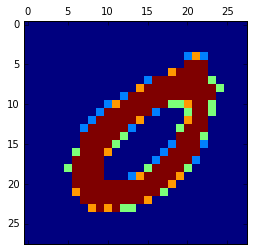

In [10]:
train = scio.loadmat("train.mat")
test = scio.loadmat("test.mat")
print train['train_images'].shape
train_images = train['train_images'].T.reshape(60000, 784)
train_labels = train['train_labels']
shuffle_in_unison(train_images, train_labels)
plt.matshow(train_images[0].reshape(28,28).T)
print train_labels[0]
train_iset = train_images[:5000]
train_lset = train_labels[:5000]
test_iset = train_images[5000:7000]
test_lset = train_labels[5000:7000]

In [11]:
means = kmeans(train_iset, 10)

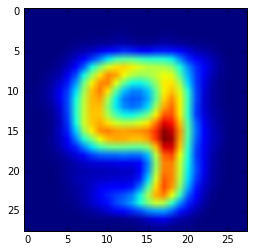

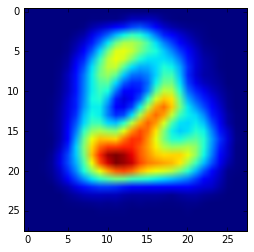

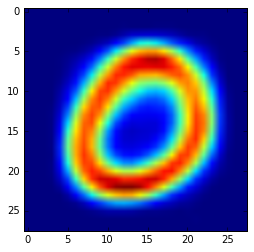

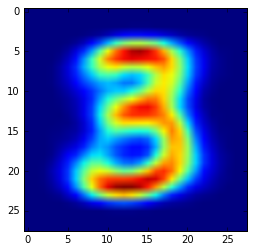

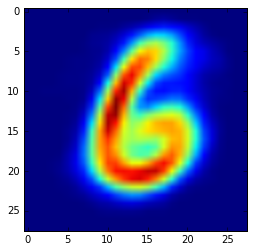

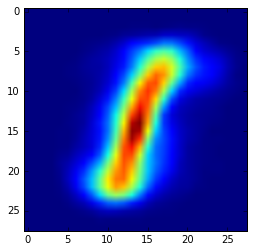

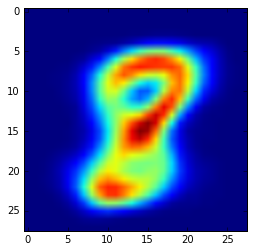

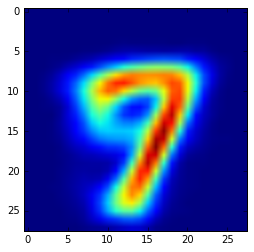

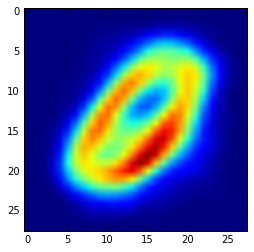

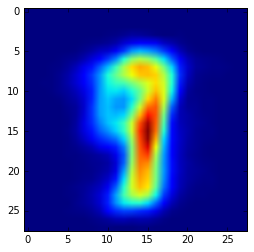

In [15]:
for i in range(10):
    plt.figure()
    plt.imshow(means[0][i].reshape(28,28).T)
def kmeans_classifier(image, means=means[0]): 
    ordered_means = [means[2],means[5],means[1],means[3],means[0],means[8],means[4],means[7],means[6],means[9]]
    lowest = np.linalg.norm(ordered_means[0])
    bstidx = 0
    idx = 0
    for mean in ordered_means:
        dist = np.linalg.norm(mean-image)
        if dist < lowest:
            lowest = dist
            bstidx = idx
            if idx == 5:
                bstidx = 0
        idx += 1
    return bstidx

In [17]:
results = cluster_classify(kmeans_classifier, test_iset, test_lset)

In [18]:
means = kmeans(train_iset, 100)

In [23]:
values = assign_centers(means[0], train_iset)

In [30]:
def expand(pt, px):
    '''
    creates a matrix of dimension (len(px), len(pt))
    '''
    try:
        return np.array([pt for i in range(len(px))])
    except TypeError:
        return np.array([pt for i in range(px)])

def joint_dist(x, yx):
    '''
    Creates a joint distribution from a distribution p(x) and p(y|x) 
    the rows are the x values, the columns are the y values
    '''
    return (np.array(expand(x, yx.shape[0])) * yx).T

def product_dist(x, y):
    '''
    creates the product distribution of x,y, where x is the row index and
    y is the column index
    '''
    return np.array([x for i in range(len(y))]).T * np.array([y for i in range(len(x))])

def multi_sum_dist(px, py, pi):
    '''
    returns the distribution x + y for x,y of the same shape
    '''
    sumdist = Counter()
    for i in range(px.shape[0]):
        for j in range(px.shape[0]):
            for k in range(px.shape[1]):
                sumdist[i*pi[0]+j*pi[1], k] += px[i,k]*py[j,k]
#     print sumdist
    keys = sumdist.keys()
    keysx = list(set([keys[i][0] for i in range(len(keys))]))
    keysy = list(set([keys[i][1] for i in range(len(keys))]))
    keysx.sort()
    keysy.sort()
#     print keysx
#     print keysy
    values = []
    for x in keysx:
        yvals = []
        for y in keysy:
            if x == int(x) and y == int(y):
                yvals.append(sumdist[(x,y)])
        if yvals:
            values.append(yvals)
#     print values
    return np.asarray(values)
#     return np.array([sumdist[val] for val in keys if val == int(val) ])

def sum_dist(px, py, pi):
    '''
    returns the distribution x + y
    '''
    xvals = [i for i in range(px.shape[0])]
    yvals = [i for i in range(py.shape[0])]

    sumdist = Counter()
    for valx in xvals:
        for valy in yvals:
            
            sumdist[valx*pi[0]+valy*pi[1]] += px[valx]*py[valy]
#     print sumdist
    keys = sumdist.keys()
    keys.sort()
    return np.array([sumdist[val] for val in keys if val == int(val)])

In [31]:
yx = np.array([[.3, .4,.8],[.7, .6,.2]])
# y = np.sum(expand(x, 2)*yx, axis=1)
print multi_sum_dist(yx, yx, (.5,.5))

[[ 0.09  0.16  0.64]
 [ 0.49  0.36  0.04]]


In [44]:
def hamming_distortion(x,y):
    '''
    for input vectors x, y of values, returns the hamming distortion
    of the values, as a matrix of x by y values
    '''
    values = np.ones((x.shape[0], y.shape[0]))
    for xi in range(x.shape[0]):
        for yi in range(y.shape[0]):
            if x[xi] == y[yi]:
                values[xi, yi] = 0
    return values

def blahut_arimoto(px, k, beta, distortion, epsilon = 1e-10): 
    '''
    finds the unique point of the rate distortion curve, for the
    distribution px, with distortion tradeoff beta and distortion function
    distortion, which takes in the vector of x values and vector of t values (
        0,...,x and 0,...,k respectively) and outputs the matrix of differences)
    '''
    # Ptx = np.array([0 for i in range(px.shape[0])])
    pt = np.random.rand(k)
    pt = pt/np.sum(pt)
    print pt
#     print pt
    lastR = 99999999
    R = 9999999
    tvals = np.array([i for i in range(k)])
    xvals = np.array([i for i in range(len(px))])
    itr = 0
    while  itr < 10000:
        itr += 1 
        lastR = R
        pxboost = np.array([px for i in range(k)])
        ptboost = expand(pt, px)
        Ptx = ptboost.T * np.exp(-beta*distortion(tvals, xvals))
        ptnorm = np.sum(Ptx, axis = 0)
        Ptx = Ptx/ptnorm
        pt = np.sum(Ptx * pxboost, axis = 1)
        R = kl_divergence(joint_dist(px, Ptx), product_dist(px, pt))
    print itr
    return R, Ptx, pt, joint_dist(px, Ptx), product_dist(px, pt)

In [64]:
dist = blahut_arimoto(prior_dist, 10, 740, hamming_distortion)
print dist[2]

[ 0.09055695  0.13372608  0.01760244  0.07384933  0.09765269  0.15415147
  0.14932961  0.07302949  0.12974867  0.08035327]
10000
[ 0.90247748  0.00933888  0.01374329  0.00753708  0.01787697  0.00653608
  0.01787697  0.00773728  0.01013969  0.00673628]


c:\python27\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in divide
c:\python27\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: divide by zero encountered in log2
c:\python27\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in multiply


In [22]:
a,b,c = .1,.1,.3
beta = 10
blahut_arimoto([a,b,c,1-a-b-c], 2, beta, hamming_distortion)

39


(0.19985591023819091,
 array([[  9.99954605e-01,   4.54011636e-05,   5.00018145e-01,
           5.00018145e-01],
        [  4.53945740e-05,   9.99954599e-01,   4.99981855e-01,
           4.99981855e-01]]),
 array([ 0.50001452,  0.49998548]),
 array([[  9.99954605e-02,   4.53945740e-06],
        [  4.54011636e-06,   9.99954599e-02],
        [  1.50005443e-01,   1.49994557e-01],
        [  2.50009072e-01,   2.49990928e-01]]),
 array([[ 0.05000145,  0.04999855],
        [ 0.05000145,  0.04999855],
        [ 0.15000435,  0.14999565],
        [ 0.25000726,  0.24999274]]))

# bernoulli 1/2 distribution

In [23]:
p = .5
betas = []
betavals = [i*.1 for i in range(20)] + list(range(2, 10))
for beta in betavals:
    betas.append(blahut_arimoto([1-p,p], 2, beta, hamming_distortion))

2
1472
492
325
180
147
91
67
45
56
44
17
39
24
22
22
13
17
16
15
12
8
6
5
5
5
4
3


In [24]:
R5 = [betas[i][0] for i in range(len(betas))]
Rp5 = [betas[i][2][0] for i in range(len(betas))]

[0.0, 0.0018010972286905957, 0.0071775625254560244, 0.016049534629349618, 0.028286909221046097, 0.043713459914109395, 0.062112369076433402, 0.083232787487157442, 0.10679708643875631, 0.1325084493318765, 0.16005846191406992, 0.18913439338132845, 0.21942591361838959, 0.25063104851090201, 0.28246124354399949, 0.31464546486369949, 0.34693332472570415, 0.37909726517286435, 0.41093386973807633, 0.4422643986413593, 0.47293465898689452, 0.72464005270475518, 0.87002072533359964, 0.94203308584752543, 0.97502489433260864, 0.98948444858609896, 0.99564564712765713, 0.99821978158722002]


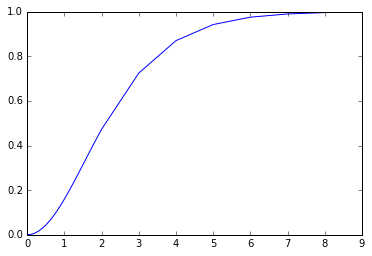

In [26]:
#R values .5
print R5
plt.plot(betavals, R5)


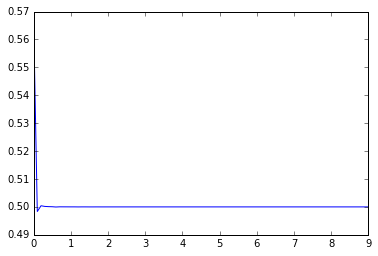

In [27]:
# prior probabiltiy compression over beta
plt.plot(betavals, Rp5)

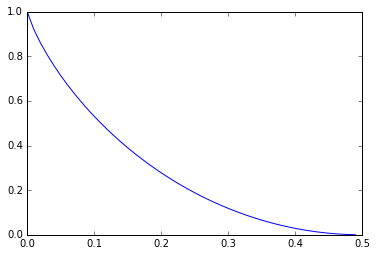

In [28]:
# R(D) values over increasing D
D = [.01*i for i in range(1,50)]
Ri = [entropy([.5, .5]) - entropy([d, 1-d]) for d in D]
plt.plot([0] + D,[1] + Ri)

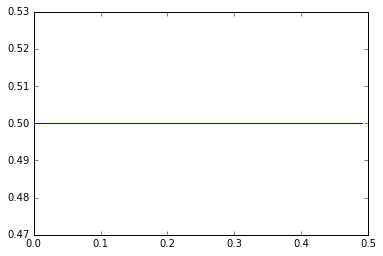

In [29]:
D = [.01*i for i in range(0,50)]
tp = [(.5-d)/(1.0-2*d) for d in D]
plt.plot(D, tp)

In [38]:
p = .3
betas = []
betavals = [i*.1 for i in range(20)] + list(range(2, 10))
for beta in betavals:
    betas.append(blahut_arimoto([1-p,p], 2, beta, hamming_distortion))
R3 = [betas[i][0] for i in range(len(betas))]
Rp3 = [betas[i][2][1] for i in range(len(betas))]


2
394
267
213
224
216
236
337
811
690
264
158
114
88
73
59
49
44
38
35
32
15
10
8
7
6
5
5


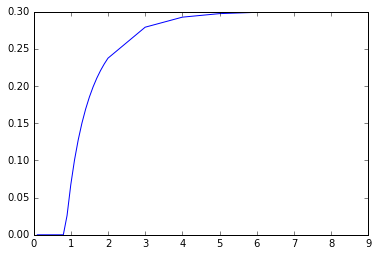

In [39]:
#prior probabilities over beta
plt.plot(betavals[1:], Rp3[1:])

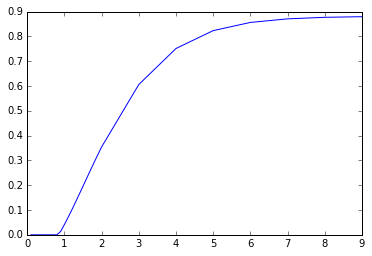

In [40]:
#Rd values
plt.plot(betavals[1:], R3[1:])

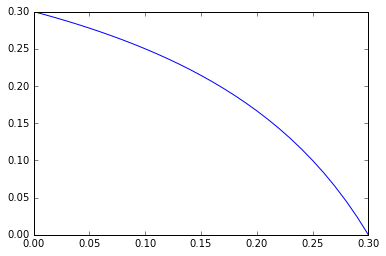

In [41]:
D = [.01*i for i in range(0,31)]
tp = [(.3-d)/(1.0-2*d) for d in D]
plt.plot(D, tp)

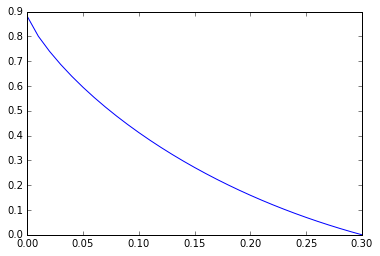

In [42]:
D = [.01*i for i in range(1,31)]
Ri = [entropy([.7, .3]) - entropy([d, 1-d]) for d in D]
plt.plot([0] + D,[entropy([.7, .3])] + Ri)

In [383]:
RDps = []

for p in np.linspace(0.001,.5, 20):
    betas = []
    for beta in [.5,.6,.7,.8,.9] + list(range(1, 20)):
        betas.append(blahut_arimoto([1-p,p], 2, beta, hamming_distortion))
    RDps.append(betas)


32
29
26
24
21
22
11
10
10
13
23
148
18
11
8
7
5
5
4
4
4
3
3
3
41
39
36
29
28
26
22
40
49
17
11
8
7
6
5
5
4
4
4
4
3
3
3
3
49
37
39
34
33
31
34
152
22
12
9
7
6
5
5
4
4
4
4
4
3
3
3
3
54
46
41
41
39
36
62
43
17
10
8
7
6
5
5
5
4
4
3
3
3
3
3
3
62
54
52
48
45
42
177
30
15
10
8
7
6
5
5
4
4
3
4
3
4
3
3
3
67
53
58
55
54
58
194
25
14
10
8
6
5
5
5
4
4
4
4
3
3
3
3
3
81
62
71
62
69
65
80
22
12
9
7
6
5
5
5
5
4
4
4
3
3
3
3
3
87
76
79
74
83
90
57
19
12
9
7
6
5
5
5
4
4
4
4
3
3
3
3
3
100
97
98
99
113
129
46
18
11
9
7
6
5
5
4
4
4
4
3
3
3
3
3
3
120
119
107
124
164
228
39
18
11
8
7
6
5
5
4
4
4
4
3
3
3
3
3
3
145
149
169
205
314
1101
35
16
10
8
7
6
5
5
4
4
4
4
3
3
3
3
3
3
190
207
262
442
5695
358
33
16
11
8
7
6
5
5
4
4
3
4
3
3
3
3
3
3
258
335
637
1276
328
184
31
15
10
8
7
5
5
5
4
4
4
3
3
3
3
3
3
3
449
929
932
321
193
133
28
15
8
8
7
5
5
5
4
4
4
4
3
3
3
3
3
3
1442
847
329
207
134
116
29
16
10
8
6
6
5
4
4
4
4
4
3
3
3
3
3
3
698
380
225
162
124
96
24
13
8
7
6
6
5
4
4
4
4
3
3
3
3
3
3
3
480
257
198
146
109
82
24
1

In [384]:
print np.linspace(0.001,.5, 20)[10], ([.5,.6,.7,.8,.9] + list(range(1, 20)))[6], RDps[10][5]

0.263631578947 2 (7.8200610041395934e-09, array([[  9.99999996e-01,   9.99999968e-01],
       [  4.35261577e-09,   3.21617212e-08]]), array([  9.99999988e-01,   1.16839741e-08]), array([[  7.36368418e-01,   3.20512880e-09],
       [  2.63631570e-01,   8.47884534e-09]]), array([[  7.36368412e-01,   8.60370959e-09],
       [  2.63631576e-01,   3.08026455e-09]]))


In [515]:
np.array(R)

array([[[  6.22400103e-01,   3.77481444e-01],
        [  3.77599897e-01,   6.22518556e-01]],

       [[  6.45695974e-01,   3.54383364e-01],
        [  3.54304026e-01,   6.45616636e-01]],

       [[  6.68158606e-01,   3.31783063e-01],
        [  3.31841394e-01,   6.68216937e-01]],

       [[  6.89994314e-01,   3.10045352e-01],
        [  3.10005686e-01,   6.89954648e-01]],

       [[  7.10934510e-01,   2.89035505e-01],
        [  2.89065490e-01,   7.10964495e-01]],

       [[  7.31047373e-01,   2.68930216e-01],
        [  2.68952627e-01,   7.31069784e-01]],

       [[  8.80796192e-01,   1.19202036e-01],
        [  1.19203808e-01,   8.80797964e-01]],

       [[  9.52573807e-01,   4.74255531e-02],
        [  4.74261933e-02,   9.52574447e-01]],

       [[  9.82013772e-01,   1.79861918e-02],
        [  1.79862281e-02,   9.82013808e-01]],

       [[  9.93307149e-01,   6.69285054e-03],
        [  6.69285131e-03,   9.93307149e-01]],

       [[  9.97527377e-01,   2.47262312e-03],
        [  2.4

In [710]:
import warnings

def fxn():
    warnings.warn("diverr", RuntimeWarning)

with warnings.catch_warnings(record=True) as w:
    # Cause all warnings to always be triggered.
    warnings.simplefilter("always")
    # Trigger a warning.
    fxn()
    # Verify some things
    assert len(w) == 1
    assert issubclass(w[-1].category, DeprecationWarning)
    assert "deprecated" in str(w[-1].message)

AssertionError: 

In [186]:
def iterative_IB(pxy, beta, k, epsilon  =1e-5, maxitr = 10000):
    '''
    converges to a local optimum of the p(t|x) distribution 
    Note capital P denotes a probability distribution given a value
    and lower case is joint probability
    '''
    # Ptx = np.array([0 for i in range(px.shape[0])])
    
    itr = 0
    tiny = .00000001
#     while itr < 1000:
    Ptx = np.random.rand(k, pxy.shape[0])
    Ptx = np.nan_to_num(Ptx/np.sum(Ptx, axis = 0))
    px = np.nan_to_num(np.sum(pxy, axis = 1)/np.sum(pxy))
    print np.sum(px)
    pxboost = expand(px, k)
    Pyx = np.nan_to_num(pxy.T/px)
    pt = np.sum(Ptx * pxboost, axis = 1)
    print pt
    Pyt = np.nan_to_num(np.dot(Ptx,pxy).T/pt)
    itr = 0
    while itr<maxitr:
        itr += 1
        lastPtx = Ptx
        Ptx = np.array([pt for i in range(len(px))]).T * np.exp(-beta*expanded_kl_divergence(Pyx, Pyt))
        ptnorm = np.sum(Ptx, axis = 0)

        Ptx = np.nan_to_num(Ptx/ptnorm)
        pxboost = expand(px, k)
        pt = np.sum(Ptx * pxboost, axis = 1)
#         print pt
#         print Ptx
        Pyt = np.nan_to_num(np.dot(Ptx,pxy).T/pt)
        for val in pt:
            if val + tiny >= 1:
                break
            if np.isnan(val):
                break
        if js_divergence(Ptx, lastPtx,(.5, .5)) <= epsilon:
            break
    print itr
    return Ptx, pt, Pyt

In [1003]:
p= .3
px = np.array([p,1-p])
Pyx = np.array([[0.3, .9],[.7,.1]])
pxy = joint_dist(px, Pyx)
print pxy.T/px
iterative_IB(pxy, 4, 2, 1e-1, 10000)

[[ 0.3  0.9]
 [ 0.7  0.1]]
10000


(array([[ 0.42725954,  0.99895865],
        [ 0.57274046,  0.00104135]]),
 array([ 0.82744892,  0.17255108]),
 array([[ 0.80705563,  0.3025347 ],
        [ 0.19294437,  0.6974653 ]]))

In [526]:
Ptx = np.random.rand(2, pxy.shape[0])
Ptx = Ptx/np.sum(Ptx, axis = 0)

In [870]:
ibbetavals = [i*.2 for i in range(6)] + list(range(2, 15))
p = .5
px = np.array([p,1-p])
Pyx = np.array([[0.3, .9],[.7,.1]])
pxy = joint_dist(px, Pyx)
print pxy.T/px
rs = []
for beta in ibbetavals:
    rs.append(iterative_IB(pxy, beta, 2)[1][0])

[[ 0.3  0.9]
 [ 0.7  0.1]]
10000
228
104
69
58
37
16
12
10000
10
8
10000
10000
9
6
10000
10000
10000
10000


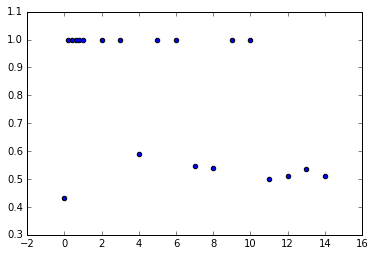

In [872]:
plt.scatter(ibbetavals, rs)

In [899]:
p = .5
px = np.array([p,1-p])
Pyx = np.array([[0.3, .9],[.7,.1]])
pxy = joint_dist(px, Pyx)
print pxy.T/px
rs = []
for beta in ibbetavals:
    vals = []
    for i in range(30):
        vals.append(iterative_IB(pxy, beta, 2)[1][0])
    print vals
    rs.append((min(vals),np.sum(vals)/20.0, max(vals)))

[[ 0.3  0.9]
 [ 0.7  0.1]]
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
[0.45944926703361055, 0.23976643027342745, 0.18618096167353582, 0.52984477879422598, 0.16374270838442476, 0.68430977226977174, 0.30745963338980814, 0.48595749081750939, 0.48632896936367032, 0.48039765295852038, 0.64202899169442151, 0.23620286409002711, 0.43773434174946091, 0.55170764654586413, 0.40586028908872945, 0.71456433024988075, 0.24268248065546308, 0.39723961460301283, 0.79408970030624437, 0.31618153400082005, 0.52914831484334257, 0.88818143932808702, 0.40976967323726754, 0.59705522466068905, 0.6304973186845747, 0.4277978039871097, 0.51464423140414928, 0.43523900937227844, 0.18993241945833972, 0.77298356364414089]
222
233
216
232
230
227
231
231
224
226
229
210
220
228
239
232
230
235
227
241
224
230
226
237
232
237
232
215
218
228
[0.99999999999889688, 0.9999999999988618, 0.

In [900]:
rs

[(0.16374270838442476, 0.70784892282812029, 0.88818143932808702),
 (0.99999999999885691, 1.4999999999983795, 0.99999999999897637),
 (0.99999999999895151, 1.4999999999985669, 0.99999999999915612),
 (0.9999999999990512, 1.4999999999988012, 0.99999999999935185),
 (0.99999999999914713, 1.4999999999990121, 0.99999999999952394),
 (0.99999999999929945, 1.4999999999992881, 0.9999999999997029),
 (0.99999999999975875, 1.4999999999998308, 0.9999999999999627),
 (0.63351563384828091, 1.2434609436937702, 0.99999999999999267),
 (0.58959952093246171, 1.2742797365128398, 0.99999999999999789),
 (0.56903697249879259, 1.1767777293740915, 0.99999999999999956),
 (0.5557894622648466, 1.2334736773589066, 0.99999999999999989),
 (0.5463473836499696, 1.114395276102474, 1.0),
 (0.51145506386946227, 0.96318766079012674, 1.0),
 (0.5051567201008863, 1.0922336829836221, 1.0),
 (0.50268217386894343, 1.0030801036351087, 1.0),
 (0.50146945113879349, 1.0831990875018804, 1.0),
 (0.50082624998191816, 1.1409966049259395, 1.

In [877]:
rsttf = []
ttfvals = np.linspace(1.8,4,22)
for beta in ttfvals:
    vals = []
    for i in range(30):
        vals.append(iterative_IB(pxy, beta, 2)[1][0])
    print vals
    rsttf.append((min(vals),np.sum(vals)/20.0, max(vals)))


18
18
16
20
20
17
19
17
16
16
18
18
16
19
23
15
15
18
14
18
20
17
17
22
18
15
17
16
13
17
[0.99999999999984723, 0.99999999999989497, 0.99999999999983635, 0.99999999999992562, 0.99999999999991052, 0.99999999999985478, 0.99999999999992628, 0.99999999999988443, 0.99999999999985523, 0.99999999999977429, 0.99999999999987321, 0.99999999999993006, 0.99999999999994582, 0.99999999999971101, 0.99999999999977263, 0.99999999999985778, 0.99999999999991029, 0.99999999999977041, 0.99999999999992628, 0.99999999999970934, 0.99999999999990608, 0.99999999999994371, 0.99999999999970812, 0.99999999999994305, 0.99999999999989109, 0.99999999999992195, 0.99999999999993672, 0.99999999999993028, 0.99999999999983558, 0.99999999999992872]
20
19
21
19
21
14
23
18
19
18
19
20
13
18
19
17
15
18
15
17
19
16
23
19
15
14
20
17
18
16
[0.99999999999982592, 0.99999999999994027, 0.99999999999994926, 0.99999999999973599, 0.99999999999992206, 0.99999999999986977, 0.99999999999994837, 0.9999999999999245, 0.99999999999979328, 

In [886]:
rssee = []
seevals = np.linspace(6.9,8,12)
for beta in seevals:
    vals = []
    for i in range(30):
        vals.append(iterative_IB(pxy, beta, 2)[1][0])
    print vals
    rssee.append((min(vals),np.sum(vals)/20.0, max(vals)))

7
10000
10000
10000
10000
10000
10000
10000
10000
6
10000
10000
20
10000
10000
8
10000
10000
10000
17
8
16
7
10000
10000
18
28
25
10000
8
[0.99999999999999978, 0.54716923465326084, 0.54716923465326117, 0.54716923465326117, 0.54716923465326084, 0.54716923465326106, 0.54716923465326073, 0.54716923465326073, 0.54716923465326084, 0.99999999999999889, 0.54716923465326073, 0.54716923465326084, 0.99999999999999867, 0.54716923465326084, 0.54716923465326084, 1.0, 0.54716923465326084, 0.54716923465326084, 0.54716923465326073, 0.99999999999999956, 1.0, 0.99999999999999467, 1.0, 0.54716923465326117, 0.54716923465326084, 0.99999999999999778, 0.99999999999999978, 0.99999999999999833, 0.54716923465326106, 1.0]
10000
10000
10000
28
10000
7
4
14
7
7
10000
6
10000
6
10000
10000
10000
7
5
6
10000
10000
6
11
12
10000
5
17
6
8
[0.5463473836499696, 0.54634738364997049, 0.54634738364997049, 1.0, 0.5463473836499696, 0.99999999999999978, 0.99999999999999856, 0.99999999999999933, 0.99999999999999978, 1.0, 0.546

array([ 6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,
        8. ])

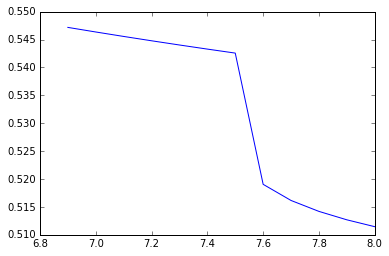

In [888]:
rssevals = [sse[0] for sse in rssee]
plt.plot(seevals, rssevals)
seevals

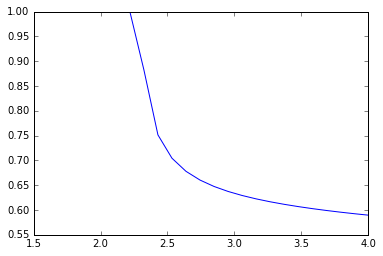

In [878]:
rsttfvals = [tf[0] for tf in rsttf]
plt.plot(ttfvals, rsttfvals)

In [891]:
ibbetavals[11:]

[7, 8, 9, 10, 11, 12, 13, 14]

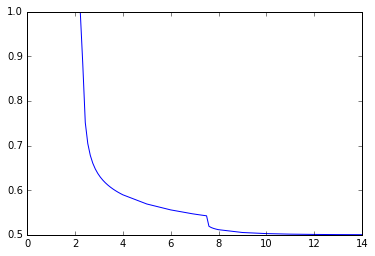

In [896]:
newall = ibbetavals[:7]  + ttfvals[2:].tolist() + ibbetavals[9:11] + seevals.tolist() + ibbetavals[13:]
plt.plot(newall[1:], rslower[1:7] + rsttfvals[2:] + rslower[9:11] + rssevals + rslower[13:])

In [897]:
np.savetxt("mindata.txt", rslower[0:7] + rsttfvals[2:] + rslower[9:11] + rssevals + rslower[13:])
np.savetxt("ranges.txt", newall)

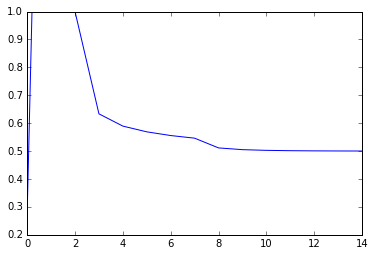

In [876]:
rslower = [rsv[0] for rsv in rs]
plt.plot(ibbetavals, rslower)

In [908]:
p = .3
px = np.array([p,1-p])
Pyx = np.array([[.3, .9],[.7,.1]])
pxy = joint_dist(px, Pyx)
print pxy.T/px
rsns = []
for beta in ibbetavals:
    if beta == 0:
        continue
    vals = []
    for i in range(30):
        vals.append(iterative_IB(pxy, beta, 2)[1][0])
    print vals
    rsns.append((min(vals),np.max([0] + [val for val in vals if val + .0001 <= 1]), max(vals)))

[[ 0.3  0.9]
 [ 0.7  0.1]]
100
112
112
114
105
107
108
108
108
102
106
102
118
111
112
111
111
107
107
106
111
114
109
110
110
106
110
108
105
103
[0.99999999999914957, 0.99999999999915545, 0.99999999999903921, 0.99999999999912914, 0.99999999999909461, 0.99999999999898825, 0.99999999999908384, 0.99999999999914002, 0.99999999999911227, 0.9999999999990532, 0.99999999999909617, 0.99999999999892908, 0.99999999999913403, 0.99999999999910216, 0.99999999999897904, 0.99999999999897904, 0.99999999999893596, 0.9999999999990915, 0.99999999999904854, 0.99999999999900657, 0.99999999999893907, 0.99999999999893119, 0.99999999999908162, 0.99999999999896771, 0.99999999999906064, 0.99999999999905476, 0.9999999999991116, 0.9999999999989877, 0.9999999999990592, 0.99999999999914824]
53
53
55
53
56
51
56
59
58
57
59
55
53
57
53
53
53
54
52
54
57
55
53
57
54
54
53
53
50
54
[0.99999999999931521, 0.99999999999926814, 0.99999999999910261, 0.99999999999935341, 0.9999999999991247, 0.99999999999936806, 0.999999999

In [912]:
print rsns
rsnsbstn = [rsn[1] for rsn in rsns]
rsnsbst = []
for val in rsnsbstn:
    if val == 0:
        rsnsbst.append(1)
    else:
        rsnsbst.append(val)


[(0.99999999999892908, 0, 0.99999999999915545), (0.99999999999904998, 0, 0.9999999999994249), (0.99999999999921119, 0, 0.99999999999963196), (0.99999999999931322, 0, 0.99999999999976463), (0.99999999999944222, 0, 0.99999999999985834), (0.99999999999985034, 0, 0.99999999999998734), (0.90376139650341891, 0.90376139650341902, 0.99999999999999933), (0.82744892058943087, 0.82744892058943087, 1.0), (0.79692553568218083, 0.79692553568218083, 1.0), (0.77814172927578995, 0.77814172927579017, 1.0), (0.76489101398181147, 0.76489101398181147, 1.0), (0.30687303758203188, 0.75494886063305122, 1.0), (0.30309403199209994, 0.74719872093529394, 1.0), (0.30160930431539584, 0.7409859459065371, 1.0), (0.30088167068276617, 0.73589536754118001, 1.0), (0.30049574998910789, 0.73165002075068708, 1.0), (0.30028285244615488, 0.72805788171435371, 1.0), (0.30016278496085586, 0.72498157041847533, 1.0)]


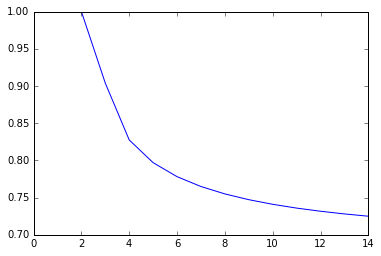

In [913]:
plt.plot(ibbetavals[1:], rsnsbst)

In [915]:
rsnsttf = []
rsnscorttf = np.linspace(2,5,40)
for beta in rsnscorttf:
    if beta == 0:
        continue
    vals = []
    for i in range(30):
        vals.append(iterative_IB(pxy, beta, 2)[1][0])
    print vals
    rsnsttf.append((min(vals),np.max([0] + [val for val in vals if val + .0001 <= 1]), max(vals)))


15
13
12
13
11
12
13
12
13
13
14
12
12
16
16
12
13
14
12
12
11
14
12
12
12
11
14
12
12
10
[0.9999999999999839, 0.99999999999997591, 0.9999999999999043, 0.9999999999999839, 0.99999999999994293, 0.99999999999983546, 0.9999999999999285, 0.99999999999987854, 0.99999999999993294, 0.99999999999998279, 0.99999999999997247, 0.99999999999998501, 0.99999999999983946, 0.99999999999992961, 0.99999999999996025, 0.99999999999995937, 0.99999999999997247, 0.99999999999997979, 0.99999999999989431, 0.99999999999983902, 0.99999999999994982, 0.99999999999997935, 0.99999999999995492, 0.99999999999992917, 0.99999999999997136, 0.99999999999993461, 0.99999999999987121, 0.99999999999993006, 0.99999999999996092, 0.9999999999999778]
17
12
15
14
11
13
13
12
12
11
14
12
11
6
10
11
13
12
11
12
13
12
12
15
12
12
13
11
12
13
[0.99999999999998379, 0.99999999999998512, 0.99999999999998979, 0.99999999999998002, 0.99999999999995048, 0.99999999999995159, 0.99999999999997846, 0.9999999999999698, 0.99999999999988687, 0.9999

NameError: name 'rsnsccorft' is not defined

[(0.99999999999892908, 0, 0.99999999999915545), (0.99999999999904998, 0, 0.9999999999994249), (0.99999999999921119, 0, 0.99999999999963196), (0.99999999999931322, 0, 0.99999999999976463), (0.99999999999944222, 0, 0.99999999999985834), (0.99999999999985034, 0, 0.99999999999998734), (0.90376139650341891, 0.90376139650341902, 0.99999999999999933), (0.82744892058943087, 0.82744892058943087, 1.0), (0.79692553568218083, 0.79692553568218083, 1.0), (0.77814172927578995, 0.77814172927579017, 1.0), (0.76489101398181147, 0.76489101398181147, 1.0), (0.30687303758203188, 0.75494886063305122, 1.0), (0.30309403199209994, 0.74719872093529394, 1.0), (0.30160930431539584, 0.7409859459065371, 1.0), (0.30088167068276617, 0.73589536754118001, 1.0), (0.30049574998910789, 0.73165002075068708, 1.0), (0.30028285244615488, 0.72805788171435371, 1.0), (0.30016278496085586, 0.72498157041847533, 1.0)]


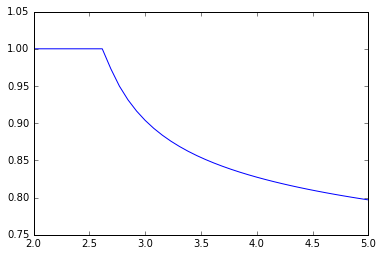

In [916]:
print rsns
rsnsbstttfn = [rsn[1] for rsn in rsnsttf]
rsnsbstttf = []
for val in rsnsbstttfn:
    if val == 0:
        rsnsbstttf.append(1)
    else:
        rsnsbstttf.append(val)
plt.plot(rsnscorttf, rsnsbstttf)

In [917]:
rsnsft = []
rsnscorft = np.linspace(15,40,25)
for beta in rsnscorft:
    if beta == 0:
        continue
    vals = []
    for i in range(30):
        vals.append(iterative_IB(pxy, beta, 2)[1][0])
    print vals
    rsnsft.append((min(vals),np.max([0] + [val for val in vals if val + .0001 <= 1]), max(vals)))

10000
10000
10000
10000
4
10000
10000
10000
10000
3
10000
10000
2
10000
10000
5
10000
10000
2
2
10000
10000
4
3
10000
3
4
3
3
10000
[0.72232017612187582, 0.30009417918573444, 0.72232017612187704, 0.30009417918573444, 1.0, 0.72232017612187704, 0.72232017612187704, 0.72232017612187704, 0.72232017612187571, 1.0, 0.72232017612187704, 0.30009417918573444, 0.99999999999999856, 0.72232017612187693, 0.72232017612187704, 1.0, 0.30009417918573444, 0.30009417918573444, 1.0, 1.0, 0.30009417918573444, 0.30009417918573444, 1.0, 1.0, 0.30009417918573444, 1.0, 1.0, 1.0, 1.0, 0.72232017612187582]
10000
10000
2
10000
2
10000
10000
4
3
10000
10000
5
10000
5
2
4
10000
3
3
10000
4
3
3
5
10000
10000
10000
10000
10000
10000
[0.71990757946315365, 0.30005344210130547, 1.0, 0.7199075794631532, 1.0, 0.71990757946315365, 0.30005344210130547, 1.0, 1.0, 0.71990757946315365, 0.7199075794631532, 1.0, 0.30005344210130547, 1.0, 1.0, 1.0, 0.7199075794631532, 1.0, 1.0, 0.71990757946315365, 1.0, 1.0, 1.0, 1.0, 0.719907579

[(0.99999999999892908, 0, 0.99999999999915545), (0.99999999999904998, 0, 0.9999999999994249), (0.99999999999921119, 0, 0.99999999999963196), (0.99999999999931322, 0, 0.99999999999976463), (0.99999999999944222, 0, 0.99999999999985834), (0.99999999999985034, 0, 0.99999999999998734), (0.90376139650341891, 0.90376139650341902, 0.99999999999999933), (0.82744892058943087, 0.82744892058943087, 1.0), (0.79692553568218083, 0.79692553568218083, 1.0), (0.77814172927578995, 0.77814172927579017, 1.0), (0.76489101398181147, 0.76489101398181147, 1.0), (0.30687303758203188, 0.75494886063305122, 1.0), (0.30309403199209994, 0.74719872093529394, 1.0), (0.30160930431539584, 0.7409859459065371, 1.0), (0.30088167068276617, 0.73589536754118001, 1.0), (0.30049574998910789, 0.73165002075068708, 1.0), (0.30028285244615488, 0.72805788171435371, 1.0), (0.30016278496085586, 0.72498157041847533, 1.0)]


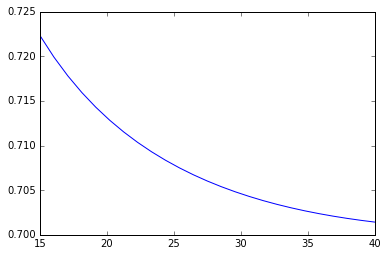

In [918]:
print rsns
rsnsbstftn = [rsn[1] for rsn in rsnsft]
rsnsbstft = []
for val in rsnsbstftn:
    if val == 0:
        rsnsbstft.append(1)
    else:
        rsnsbstft.append(val)
plt.plot(rsnscorft, rsnsbstft)

In [ ]:
plt.plot(rsnscorttf, rsnsbstttf)
plt.plot(ibbetavals[1:], rsnsbst)
plt.plot(rsnscorft, rsnsbstft)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.97312900945309022, 0.94979766047288927, 0.93134595042185553, 0.91630817124413144, 0.90376139650341902, 0.89309266313915592, 0.88387754708885469, 0.87581215084487651, 0.86867279024484256, 0.86229097284460421, 0.85653726115006368, 0.85131052334667734, 0.84653057128832598, 0.8421329954816219, 0.83806546415674177, 0.83428502148613404, 0.83075608217230412, 0.82744892058943087, 0.82433851713602702, 0.82140366656884067, 0.81862628116257519, 0.81599084060418137, 0.81348395369528015, 0.81109400616780081, 0.80881087548306385, 0.80662569821438512, 0.80453067906201181, 0.80251893309195743, 0.80058435468465627, 0.79872150810438225, 0.79692553568218083, 0.76489101398181147, 0.75494886063305122, 0.74719872093529394, 0.7409859459065371, 0.73589536754118001, 0.73165002075068708, 0.72805788171435371, 0.72498157041847533, 0.72232017612187704, 0.71990757946315365, 0.71779773622132104, 0.71594024204622941, 0.71429558180732478, 0.71283233234725663, 0.711525184

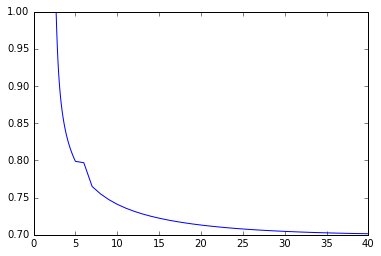

In [930]:
rsnscidx = ibbetavals[1:6] + rsnscorttf.tolist() + ibbetavals[10:] + rsnscorft.tolist()
rsnscval = rsnsbst[:6] + rsnsbstttf + rsnsbst[10:] + rsnsbstft
print rsnscval
plt.plot(rsnscidx, rsnscval)
np.savetxt("ib_differ_p", rsnscidx)
np.savetxt("ib_differ_p_vals", rsnscval)

In [237]:
results = iterative_IB(pxy, -15, 10, 1e-5, 10)

1.0
[ 0.11556265  0.06205893  0.08105789  0.10101931  0.0824508   0.11979472
  0.09535516  0.11991363  0.11228922  0.11049769]
10


c:\python27\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in divide
c:\python27\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: divide by zero encountered in log2
c:\python27\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in multiply


In [238]:
results[0]

array([[  1.61565666e-01,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
          6.11340002e-02,   6.11340002e-02,   6.11340002e-02,
        